In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from wordcloud import WordCloud, STOPWORDS

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF, Tokenizer, StringIndexer
import pyspark.sql.functions as F
from pyspark.sql.functions import when,count,lower, col, regexp_replace, split
from pyspark.sql import udf
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
#Create a Spark Session
spark = SparkSession.builder.appName('Amazon Food Sentiment').getOrCreate()

In [0]:
#Load CSV
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/erufusch@stevens.edu/reviews.csv")

In [0]:
#Check the Schema of the dataframe
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [0]:
#Typecast certain features from String to Integer
df = df.withColumn("Score",df["Score"].cast(IntegerType()))
df = df.withColumn("HelpfulnessNumerator",df["HelpfulnessNumerator"].cast(IntegerType()))
df = df.withColumn("HelpfulnessDenominator",df["HelpfulnessDenominator"].cast(IntegerType()))

In [0]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [0]:
#Drop Cloumns which will not be used for analysis
df=df.drop("Id","ProductId","UserId","ProfileName")
df.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+--------------------+----------------------+-----+----------+--------------------+--------------------+
|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|                   3|                     3|    2|1307923200|      Cough Medicine|If you are lookin...|
|                   0|                     0|    5|1350777600|         Great taffy|Great taffy at a ...|
|                   0|                     0|    4|1342051200|          Nice Taffy|I got a wild hair...|
|                   0|                     0|    5|1340

In [0]:
#Check Score Value present in the dataframe
df.select('Score').distinct().collect()

Out[165]: [Row(Score=47),
 Row(Score=None),
 Row(Score=1),
 Row(Score=13),
 Row(Score=6),
 Row(Score=16),
 Row(Score=3),
 Row(Score=5),
 Row(Score=17),
 Row(Score=9),
 Row(Score=4),
 Row(Score=8),
 Row(Score=7),
 Row(Score=10),
 Row(Score=21),
 Row(Score=33),
 Row(Score=14),
 Row(Score=2),
 Row(Score=0),
 Row(Score=65),
 Row(Score=12),
 Row(Score=22),
 Row(Score=19),
 Row(Score=15),
 Row(Score=51),
 Row(Score=29),
 Row(Score=11),
 Row(Score=18),
 Row(Score=28),
 Row(Score=57),
 Row(Score=69),
 Row(Score=25),
 Row(Score=60),
 Row(Score=40),
 Row(Score=20),
 Row(Score=54),
 Row(Score=23),
 Row(Score=24),
 Row(Score=27),
 Row(Score=32),
 Row(Score=35),
 Row(Score=30),
 Row(Score=26),
 Row(Score=49),
 Row(Score=46)]

In [0]:
#Change text from upper case to lower case and drop NA values
from pyspark.sql.functions import lower, col
df1=df.select("*", lower(col('Summary')))
df1=df1.select("*", lower(col('Text')))
df1=df1.dropna()
df1.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------------+--------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|      lower(Summary)|         lower(Text)|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------------+--------------------+
|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|good quality dog ...|i have bought sev...|
|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|   not as advertised|"product arrived ...|
|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|"""delight"" says...|"this is a confec...|
|                   3|                     3|    2|1307923200|      Cough Medicine|If you are lookin...|      cough me

In [0]:
#Drop columns which contains uppercase letters
df_drop=df1.drop("Summary","Text")
df_drop.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|
+--------------------+----------------------+-----+----------+--------------------+--------------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|
|                   0|                     0|    1|1346976000|   not as advertised|"product arrived ...|
|                   1|                     1|    4|1219017600|"""delight"" says...|"this is a confec...|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|
|                   0|                     0|    4|1342051200|          nice taffy|i got a wild hair...|
|                   0|                     0|    5|1340

In [0]:
#Filter the dataframe with only Score 1,2,4 and 5
df2 = df_drop.filter((df_drop.Score == 1) | (df_drop.Score == 2) | (df_drop.Score == 4) | (df_drop.Score == 5))
df2.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|
+--------------------+----------------------+-----+----------+--------------------+--------------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|
|                   0|                     0|    1|1346976000|   not as advertised|"product arrived ...|
|                   1|                     1|    4|1219017600|"""delight"" says...|"this is a confec...|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|
|                   0|                     0|    4|1342051200|          nice taffy|i got a wild hair...|
|                   0|                     0|    5|1340

In [0]:
#Find if there are any discrepancies HelpfulnessNumerator which can affect the EDA
df3= df2.selectExpr('*', 'HelpfulnessNumerator - HelpfulnessDenominator as Numerator_diff')
df3.show(50)

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|
|                   0|                     0|    1|1346976000|   not as advertised|"product arrived ...|             0|
|                   1|                     1|    4|1219017600|"""delight"" says...|"this is a confec...|             0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|
|                   0|                  

In [0]:
#Collect the elements from Numerator_diff and identify if there any values above 1, fortunately 'NO'
df3.select('Numerator_diff').distinct().collect()

Out[170]: [Row(Numerator_diff=-35),
 Row(Numerator_diff=-33),
 Row(Numerator_diff=-13),
 Row(Numerator_diff=-20),
 Row(Numerator_diff=-1),
 Row(Numerator_diff=-17),
 Row(Numerator_diff=-21),
 Row(Numerator_diff=-10),
 Row(Numerator_diff=-44),
 Row(Numerator_diff=-11),
 Row(Numerator_diff=-27),
 Row(Numerator_diff=-61),
 Row(Numerator_diff=-15),
 Row(Numerator_diff=-67),
 Row(Numerator_diff=-37),
 Row(Numerator_diff=1),
 Row(Numerator_diff=-50),
 Row(Numerator_diff=-42),
 Row(Numerator_diff=-39),
 Row(Numerator_diff=-9),
 Row(Numerator_diff=-7),
 Row(Numerator_diff=-46),
 Row(Numerator_diff=-5),
 Row(Numerator_diff=-31),
 Row(Numerator_diff=-45),
 Row(Numerator_diff=-8),
 Row(Numerator_diff=-19),
 Row(Numerator_diff=-22),
 Row(Numerator_diff=-25),
 Row(Numerator_diff=-23),
 Row(Numerator_diff=-64),
 Row(Numerator_diff=-6),
 Row(Numerator_diff=-57),
 Row(Numerator_diff=-29),
 Row(Numerator_diff=-53),
 Row(Numerator_diff=-60),
 Row(Numerator_diff=-4),
 Row(Numerator_diff=-16),
 Row(Numera

In [0]:
#Import Libraris for removing Special Characters and Stopwords Removing
from pyspark.ml.feature import StopWordsRemover 
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, regexp_replace, split
from pyspark. sql import functions as F

from pyspark. sql import udf

In [0]:
#Function to remove special characters
def preprocessing(sparkDF,col):
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, r'http\S+', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '@\w+', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '#', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, 'RT', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, ':', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '[^A-Za-z0-9]+', ' '))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '\-', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '[ ]+', ' '))
    sparkDF = sparkDF.withColumn(col, F.trim(sparkDF[col]))

    return sparkDF

In [0]:
#Special Characters removed for lower(Text)
df_txt = preprocessing(df3,'lower(Text)')
df_txt.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|
|                   1|                     1|    4|1219017600|"""delight"" says...|this is a confect...|             0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|
|                   0|                  

In [0]:
#Special Characters removed for lower(Summary)
df_clean = preprocessing(df_txt,'lower(Summary)')
df_clean.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|
|                   0|                  

In [0]:
df_clean.printSchema()

root
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- lower(Summary): string (nullable = true)
 |-- lower(Text): string (nullable = true)
 |-- Numerator_diff: integer (nullable = true)



In [0]:
df_clean.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|
|                   0|                  

In [0]:
df_sentiment=df_clean
df_sentiment.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|
|                   0|                  

In [0]:
#Normalize Dataframe by categorizing the Score values into '1' or '0' when the Score is (1,2) and (4,5)
df_sentiment_1= df_sentiment.selectExpr('*', 'Score < 3 as Sentiment')
df_sentiment_1 = df_sentiment_1.withColumn("Sentiment", when(col("Sentiment") == "false",1).when(col("Sentiment") == "true",0))
df_sentiment_1.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|        0|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|        0|
|                   0|                     0|    5|1350777600|         great taffy|great t

In [0]:
df_sentiment_1.printSchema()

root
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- lower(Summary): string (nullable = true)
 |-- lower(Text): string (nullable = true)
 |-- Numerator_diff: integer (nullable = true)
 |-- Sentiment: integer (nullable = true)



In [0]:
#Wordcloud function is created

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib as mpl

stopwords=set(STOPWORDS)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=0.1

def show_wordcloud(data, title=None):
  wordcloud=WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words=200,
      max_font_size=40,
      scale=3,
      random_state=1
  ).generate(str(data))

  fig = plt.figure(1,figsize=(8,8))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
  plt.imshow(wordcloud)
  plt.show()

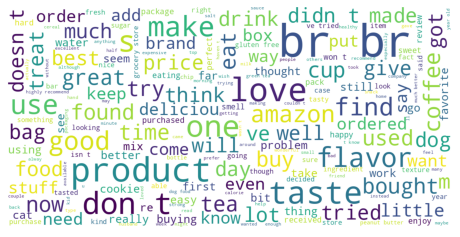

In [0]:
#Wordcloud of Text Column
wordcloud_text=df_sentiment_1.select('lower(Text)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(wordcloud_text)

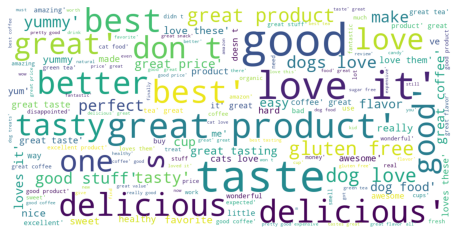

In [0]:
#Wordcloud of Summary Column
wordcloud_summary=df_sentiment_1.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(wordcloud_summary)

In [0]:
#Create a new dataframe for positive reviews
df_pos=df_sentiment_1.where(df_sentiment_1.Sentiment==1)
df_pos.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|
|                   0|                     0|    5|1350777600|         great taffy|great taffy at a ...|             0|        1|
|                   0|                     0|    4|1342051200|          nice taffy|i got a wild hair...|             0|        1|
|                   0|                     0|    5|1340150400|great just as goo...|this sa

In [0]:
#Create a new dataframe for negative reviews
df_neg=df_sentiment_1.where(df_sentiment_1.Sentiment==0)
df_neg.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|        0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|        0|
|                   1|                     1|    1|1339545600|my cats are not f...|my cats have been...|             0|        0|
|                   0|                     0|    2|1348099200|          poor taste|i love eating the...|             0|        0|
|                   0|                     1|    1|1332633600|     nasty no flavor|the can

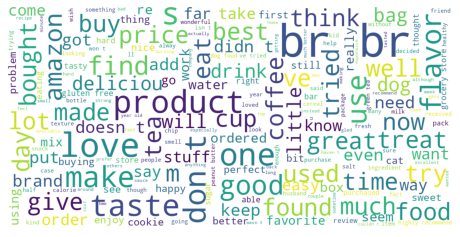

In [0]:
#Wordcloud of Positive Text
positive_text=df_pos.select('lower(Text)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(positive_text)

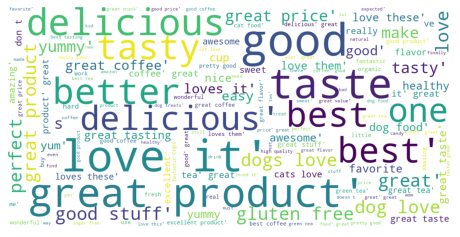

In [0]:
#Wordcloud of Positive Summary
positive_summary=df_pos.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(positive_summary)

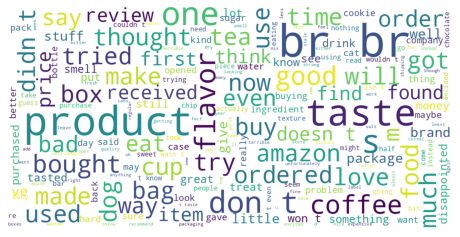

In [0]:
#Wordcloud of Negative Text
negative_text=df_neg.select('lower(Text)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(negative_text)

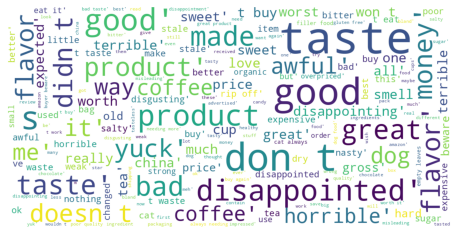

In [0]:
#Wordcloud of Negative Summary
negative_summary=df_neg.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(negative_summary)

In [0]:
# EDA to identify useful reviews
df_usefulness= df_sentiment_1.selectExpr('*', 'HelpfulnessNumerator / HelpfulnessDenominator as Usefullness')
df_usefulness.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|Usefullness|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|        1.0|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|        0|       null|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|        1.0|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|        0|        1.0|
|     

In [0]:
df_usefulness.select('Usefullness').distinct().collect()

Out[190]: [Row(Usefullness=0.9263157894736842),
 Row(Usefullness=0.7916666666666666),
 Row(Usefullness=0.926829268292683),
 Row(Usefullness=0.2631578947368421),
 Row(Usefullness=0.4166666666666667),
 Row(Usefullness=0.84),
 Row(Usefullness=0.23529411764705882),
 Row(Usefullness=0.08333333333333333),
 Row(Usefullness=0.02702702702702703),
 Row(Usefullness=0.3235294117647059),
 Row(Usefullness=0.9871794871794872),
 Row(Usefullness=0.0),
 Row(Usefullness=0.875),
 Row(Usefullness=0.3939393939393939),
 Row(Usefullness=0.7272727272727273),
 Row(Usefullness=0.4117647058823529),
 Row(Usefullness=0.13636363636363635),
 Row(Usefullness=0.9340659340659341),
 Row(Usefullness=0.9821428571428571),
 Row(Usefullness=0.029411764705882353),
 Row(Usefullness=0.08695652173913043),
 Row(Usefullness=0.7884615384615384),
 Row(Usefullness=0.18518518518518517),
 Row(Usefullness=0.9223744292237442),
 Row(Usefullness=0.9925187032418953),
 Row(Usefullness=0.9361702127659575),
 Row(Usefullness=0.9574468085106383),

In [0]:
df_usefulness.printSchema()

root
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- lower(Summary): string (nullable = true)
 |-- lower(Text): string (nullable = true)
 |-- Numerator_diff: integer (nullable = true)
 |-- Sentiment: integer (nullable = true)
 |-- Usefullness: double (nullable = true)



In [0]:
#Filter the useful reviews, here the usefule reviews are considered when they have Usefulness >0.8
df_usefulness_1 = df_usefulness.withColumn("Is_Useful", when(col("Usefullness") > 0.8,"Useful").when(col("Usefullness")<0.8,"Useless"))
df_usefulness_1.show(50)

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|Usefullness|Is_Useful|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|        1.0|   Useful|
|                   0|                     0|    1|1346976000|   not as advertised|product arrived l...|             0|        0|       null|     null|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|        1.0|   Useful|
|                   3|                     3|    2|1307923200|      cough medicine|if yo

In [0]:
#Filter only useful reviews
df_useful=df_usefulness_1.where(df_usefulness_1.Is_Useful=='Useful')
df_useful.show(25)

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|Usefullness|Is_Useful|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|        1.0|   Useful|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|        1.0|   Useful|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|        0|        1.0|   Useful|
|                   1|                     1|    5|1322006400|          yay barley|right

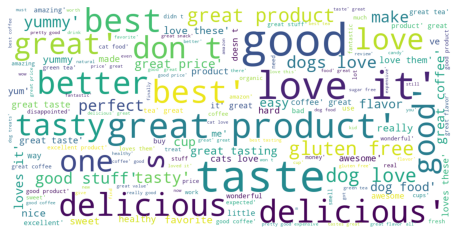

In [0]:
#Wordcloud of Useful Summary
wordcloud_summary=df_usefulness_1.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(wordcloud_summary)

In [0]:
pos_useful=df_usefulness_1.where(df_usefulness_1.Sentiment==1)

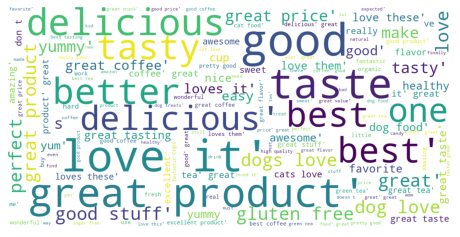

In [0]:
#Wordcloud of Useful Positive Summary
pos_summary=pos_useful.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(pos_summary)

In [0]:
neg_useful=df_usefulness_1.where(df_usefulness_1.Sentiment==0)

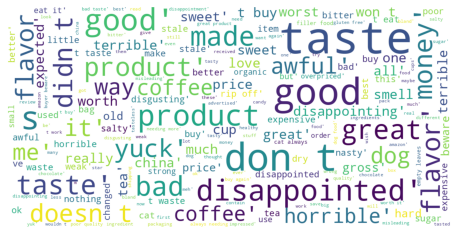

In [0]:
#Wordcloud of Useful Negative Summary
neg_summary=neg_useful.select('lower(Summary)').rdd.flatMap(lambda x: x).collect()
show_wordcloud(neg_summary)

In [0]:
#Import neccessary libraries for modeling

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [0]:
df_useful.show()

+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|      lower(Summary)|         lower(Text)|Numerator_diff|Sentiment|Usefullness|Is_Useful|
+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------+---------+-----------+---------+
|                   1|                     1|    5|1303862400|good quality dog ...|i have bought sev...|             0|        1|        1.0|   Useful|
|                   1|                     1|    4|1219017600| delight says it all|this is a confect...|             0|        1|        1.0|   Useful|
|                   3|                     3|    2|1307923200|      cough medicine|if you are lookin...|             0|        0|        1.0|   Useful|
|                   1|                     1|    5|1322006400|          yay barley|right

In [0]:
#Create dataframe of just text and Score for modeling
data=df_useful.select(
    "lower(Text)",col("Score").cast("Int").alias("label"))
data.show(truncate=False, n=5)



+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|lower(Text)                                                                                                                                                                                                                                         

In [0]:
#Split Training and Testing dataframe
split_data=data.randomSplit([0.8,0.2])

In [0]:
train=split_data[0]

#label in test renamed to true label
test=split_data[1]
train_rows=train.count()
test_rows=test.count()

In [0]:
print("Total train :",train_rows)
print("Total test :", test_rows)

Total train : 148788
Total test : 37161


In [0]:
tokenizer = Tokenizer(inputCol="lower(Text)", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(train)
#tokenizedTrain.show(truncate=False, n=5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrain = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')
numericTrain.show(truncate=False, n=3)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
#Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrain)
print ("Training Done")

Training Done


In [0]:
tokenizedTest = tokenizer.transform(test)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest)
numericTest.show(truncate=False, n=2)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------

In [0]:
#Prediction
raw_prediction = model.transform(numericTest)
raw_prediction.printSchema()

root
 |-- lower(Text): string (nullable = true)
 |-- label: integer (nullable = true)
 |-- SentimentWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MeaningfulWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
# Final_prediction = raw_prediction.select("MeaningfulWords", "prediction", "true_label")
Final_prediction = raw_prediction.select("MeaningfulWords", "prediction", "label")
#Final_prediction.show(n=4, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+
|MeaningfulWords                                                                                                                                                                                                                                                                                                                                                                        |prediction|label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
Total_True=Final_prediction.filter(Final_prediction['prediction']==Final_prediction['label']).count()
Alldata=Final_prediction.count()
Accuracy=Total_True/Alldata
print("Accuracy Score of Logistic Regression:", Accuracy*100, '%')

Accuracy Score of Logistic Regression: 81.8492505583811 %


In [0]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
ovr = OneVsRest(classifier=lr)
ovrModel = ovr.fit(numericTrain)

#score the model on test data.
predictions = ovrModel.transform(numericTest)



In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print("Accuracy Score of OneVsRest: ",ovrAccuracy*100,'%')

Accuracy Score of OneVsRest:  73.24101598553298 %


In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(numericTrain)
predictions = rfModel.transform(numericTest)

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print("Accuracy Score of Random Forest: ",rfAccuracy*100,"%")

Accuracy Score of Random Forest:  65.01262138206205 %


In [0]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Random Forest', 'OneVsRest']
accuracy = [Accuracy,rfAccuracy, ovrAccuracy]

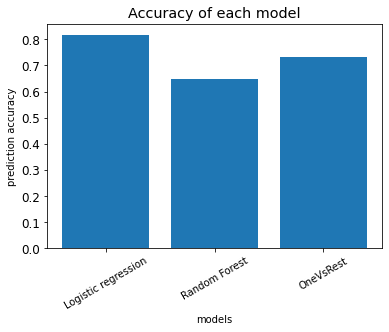

In [0]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()